> https://github.com/ukairia777/tensorflow-nlp-tutorial/blob/main/18.%20Fine-tuning%20BERT%20(Cls%2C%20NER%2C%20NLI)/18-4.%20kor_bert_nsmc_model_from_transformers_gpu.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **데이터셋 가져오기**

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [3]:
import pandas as pd

# df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/hide_subtype.csv')
df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/qna_for_git.csv', index_col=0)
# df.head()

### **sub_type을 categorical data로**

In [4]:
sub_type_mapping = {
    'type_1': 0,
    'type_2': 1,
    'type_3': 2,
    'type_4': 3,
    'type_5': 4,
    'type_6': 5,
    'type_7': 6,
    'type_8': 7,
    'type_9': 8,
    'type_10': 9,
    'type_11': 10,
    'type_12': 11,
    'type_13': 12,
    'type_14': 13,
    'type_15': 14,
    'type_16': 15,
    'type_17': 16,
    'type_18': 17,
    'type_19': 18,
    'type_20': 19,
    'type_21': 20
}

func = lambda x: sub_type_mapping.get(x, x)

In [5]:
df['sub_type'] = df['sub_type'].map(func)

### **train, test set 분리**

In [6]:
from sklearn.model_selection import train_test_split

# train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=930)

In [7]:
# drop=True 안 하면 index 열 안 사라짐
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [8]:
train_data.sub_type.nunique(), test_data.sub_type.nunique()

(21, 21)

In [9]:
print('훈련용 리뷰 개수 :', len(train_data)) # 훈련용 개수 출력
print('테스트용 리뷰 개수 :', len(test_data)) # 테스트 개수 출력

훈련용 리뷰 개수 : 4668
테스트용 리뷰 개수 : 1168


In [10]:
# train_data[:5] # 상위 5개 출력

In [11]:
# test_data[:5]

In [12]:
train_data['inquiry'].nunique(), train_data['sub_type'].nunique()

(3922, 21)

In [13]:
### 일부러 스킵
# train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

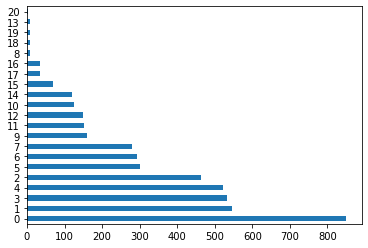

In [14]:
train_data['sub_type'].value_counts().plot(kind='barh')

In [15]:
print(train_data.groupby('sub_type').size().reset_index(name='count'))

    sub_type  count
0          0    849
1          1    545
2          2    464
3          3    532
4          4    521
5          5    300
6          6    293
7          7    280
8          8      9
9          9    160
10        10    125
11        11    153
12        12    150
13        13      8
14        14    121
15        15     70
16        16     34
17        17     36
18        18      8
19        19      8
20        20      2


In [16]:
print(test_data.groupby('sub_type').size().reset_index(name='count'))

    sub_type  count
0          0    209
1          1    130
2          2    119
3          3    140
4          4    121
5          5     89
6          6     75
7          7     68
8          8      2
9          9     20
10        10     33
11        11     37
12        12     49
13        13      5
14        14     21
15        15     20
16        16     12
17        17     12
18        18      2
19        19      2
20        20      2


In [17]:
print(train_data.isnull().values.any())

False


### **토크나이저를 이용한 정수 인코딩**
- 이미 학습해놓은 모델을 사용하다보면 (1)토크나이저, (2)모델 두 가지를 로드해야 한다.

In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 36.4 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.2 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [19]:
import transformers

transformers.__version__

'4.20.1'

> https://thebook.io/080289/ch10/02/02-05/
> - `bert-base`: 영어에 사용되도록 만들어짐
> - `bert-base-uncased`: 모든 문장을 소문자로 대체
> - 한국어를 사용하기 위해선 `bert-base-multilingual-cased`를 사용하는 것이 좋다.
> - 100개 이상의 언어를 적용할 수 있는 모델


In [20]:
# 사전 훈련된 BERT 의 토크나이저를 사용하겠다.

from transformers import BertTokenizerFast

# tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base") # 사용하고자 하는 모델 이름
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [21]:
# test_data = test_data.dropna(how='any')

print(len(test_data))

1168


In [22]:
X_train_list = train_data['inquiry'].tolist()
X_test_list = test_data['inquiry'].tolist()
y_train = train_data['sub_type'].tolist()
y_test = test_data['sub_type'].tolist()

In [23]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [24]:
# print(X_train[0].tokens)

In [25]:
print(X_train[0].ids)

[101, 9689, 42815, 22333, 9619, 18622, 84300, 11467, 9640, 58303, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


> `type_ids`: 풀고자 하는 문제에서 문장 종류의 개수를 의미
> - 일반적으로 2개 이상의 문장을 가지고 푸는 문제일 경우 [0, 0, 0, 0, 1, 1, 1, 1] 이런 식의 값이 들어가지만
> - 네이버 영화 리뷰는 문장 1개를 보고 푸는 문제이므로 [0, 0, 0, 0, 0, 0, 0, 0] 이 들어감


In [27]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### **데이터셋 생성 및 모델 학습**

In [28]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [29]:
# X_train

In [30]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [ ]:
# loss = model.compute_loss
# loss = tf.keras.losses.CategoricalCrossentropy()

In [32]:
# BERT 모델을 생성하는 단계
# 데이터를 분류하기 위해 버트 모델을 내려 받음. 토크나이저처럼 사전 훈련된 버트 모델을 명시해야 함
# from_pt=True: 파이토치에서 학습된 모델인데 tf에서 쓰게 하기 위해
# sparse_categorical_crossentropy

model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=21, from_pt=True)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.compute_loss

In [33]:
# Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
# GPU 메모리가 부족할 때 나는 에러 -> batch_size 줄이기

callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

# 32, 64, 64
model.fit(
    train_dataset.shuffle(10000).batch(16), epochs=5, batch_size=16,
    validation_data = val_dataset.shuffle(10000).batch(16),
    callbacks = [callback_earlystop]
)

Epoch 1/5
292/292 [==============================] - 306s 979ms/step - loss: 3.4013 - accuracy: 0.1611 - val_loss: 3.2497 - val_accuracy: 0.0180
Epoch 2/5
292/292 [==============================] - 285s 976ms/step - loss: 2.9662 - accuracy: 0.1078 - val_loss: 2.8902 - val_accuracy: 0.2671
Epoch 3/5
292/292 [==============================] - 284s 974ms/step - loss: 2.9711 - accuracy: 0.3025 - val_loss: 3.1027 - val_accuracy: 0.3776
Epoch 4/5
292/292 [==============================] - 283s 969ms/step - loss: 2.9101 - accuracy: 0.1967 - val_loss: 3.1696 - val_accuracy: 0.1019
Epoch 5/5
292/292 [==============================] - 284s 974ms/step - loss: 2.9013 - accuracy: 0.0994 - val_loss: 2.9455 - val_accuracy: 0.1019


In [34]:
model.evaluate(val_dataset.batch(1024))

2/2 [==============================] - 11s 1s/step - loss: 2.9455 - accuracy: 0.1019


[2.9454846382141113, 0.10188356041908264]

### **모델 저장**

In [ ]:
# model_path = '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git'

In [35]:
model_path = '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git'

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git/tokenizer_config.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git/special_tokens_map.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git/vocab.txt',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git/added_tokens.json',
 '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git/tokenizer.json')

### **모델 로드 및 테스트**

In [36]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model,
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at /content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/Following_bert/bert_model/bert-base-multilingual-cased_for_git.
If your task is similar to the task the model of the checkpoi

In [ ]:
# test_data

---

### **분류 결과 확인**

In [37]:
# # 정렬 함수

# # 맨 처음에 만든 sub_type_mapping 뒤집기 -> dic.get() 함수 쓰기 위해
# sub_type_mapping_reverse = {v: k for k, v in sub_type_mapping.items()}

# def get_category_name(sentence):
#     rank = {}
#     for i, n in enumerate(text_classifier(sentence)[0]): # 각 라벨 값, 확률값 dictionary로 새로 저장
#         rank[i] = n['score']

#     sorted_rank = dict(sorted(rank.items(), reverse=True, key=lambda x: x[1])) # dictionary 내림차순 정렬

#     # sub_category만 보고 싶을 때
#     # for key in sorted_rank.keys():
#     #     print(sub_type_mapping_reverse.get(key)) # 확률값 높은 순대로 sub_category 출력

#     # 확률값까지 보고 싶을 때
#     for key, value in sorted_rank.items():
#         print(sub_type_mapping_reverse.get(key), '  ', value)

In [94]:
# 정렬 함수

# # 맨 처음에 만든 sub_type_mapping 뒤집기 -> dic.get() 함수 쓰기 위해
sub_type_mapping_reverse = {v: k for k, v in sub_type_mapping.items()}

def get_category_name_new(sentence):
    num = len(text_classifier(sentence))

    rank = {}
    for i in range(num):
        rank[i] = text_classifier(sentence)[i]['score']
    
    sorted_rank = dict(sorted(rank.items(), reverse=True, key=lambda x: x[1]))

    for key, value in sorted_rank.items():
        print(sub_type_mapping_reverse.get(key), '  ', value)

In [95]:
get_category_name_new('네비게이션이 안 돼요')

type_3    0.19743137061595917
type_1    0.09570898115634918
type_16    0.08271124213933945
type_4    0.050022192299366
type_2    0.048005905002355576
type_6    0.04650209844112396
type_5    0.04437145218253136
type_7    0.044133663177490234
type_12    0.03970117121934891
type_8    0.03873366117477417
type_13    0.03806827962398529
type_10    0.03669830039143562
type_15    0.03446127101778984
type_11    0.03301572427153587
type_17    0.03173357620835304
type_9    0.02719571813941002
type_14    0.02544674277305603
type_18    0.024158598855137825
type_20    0.022024910897016525
type_21    0.02040213532745838
type_19    0.019472898915410042


In [96]:
get_category_name_new('타이어가 펑크났어요.')

type_3    0.19739660620689392
type_1    0.0957120880484581
type_16    0.08272471278905869
type_4    0.050019439309835434
type_2    0.04800068959593773
type_6    0.0465058758854866
type_5    0.0443648025393486
type_7    0.044133927673101425
type_12    0.03970520570874214
type_8    0.038731809705495834
type_13    0.03807046636939049
type_10    0.036700595170259476
type_15    0.03446216508746147
type_11    0.033016759902238846
type_17    0.0317348949611187
type_9    0.027198871597647667
type_14    0.02545025572180748
type_18    0.02416178025305271
type_20    0.022028427571058273
type_21    0.020405380055308342
type_19    0.0194753035902977


In [97]:
get_category_name_new('주차 딱지가 붙었는데 어떡하죠?')

type_3    0.19740916788578033
type_1    0.09571141749620438
type_16    0.08272082358598709
type_4    0.05001891776919365
type_2    0.0480029322206974
type_6    0.046503931283950806
type_5    0.044366709887981415
type_7    0.044133447110652924
type_12    0.03970441222190857
type_8    0.03873223066329956
type_13    0.03806928172707558
type_10    0.03669924661517143
type_15    0.03446200117468834
type_11    0.033016402274370193
type_17    0.031734757125377655
type_9    0.027198001742362976
type_14    0.025449099019169807
type_18    0.024160858243703842
type_20    0.02202748693525791
type_21    0.02040431834757328
type_19    0.019474556669592857


In [98]:
get_category_name_new('자동차 전기 충전이 안 돼요 ㅠㅠ')

type_3    0.197434201836586
type_1    0.09570755809545517
type_16    0.082713283598423
type_4    0.0500187948346138
type_2    0.04800606518983841
type_6    0.04650065675377846
type_5    0.04437175393104553
type_7    0.04413305222988129
type_12    0.03970203548669815
type_8    0.03873296082019806
type_13    0.03806719183921814
type_10    0.03669802471995354
type_15    0.03446190804243088
type_11    0.033015355467796326
type_17    0.03173479437828064
type_9    0.027195949107408524
type_14    0.02544659562408924
type_18    0.024158790707588196
type_20    0.022025475278496742
type_21    0.02040248177945614
type_19    0.019473152235150337


In [99]:
get_category_name_new('충전기')

type_3    0.19741687178611755
type_1    0.09571179747581482
type_16    0.08271928131580353
type_4    0.05002274364233017
type_2    0.04800580441951752
type_6    0.046502090990543365
type_5    0.04436907172203064
type_7    0.04413194581866264
type_12    0.03970162943005562
type_8    0.03873157873749733
type_13    0.038067907094955444
type_10    0.03669894114136696
type_15    0.03446013852953911
type_11    0.03301553055644035
type_17    0.03173511475324631
type_9    0.02719718962907791
type_14    0.02544691599905491
type_18    0.024160735309123993
type_20    0.022026587277650833
type_21    0.020404202863574028
type_19    0.019473809748888016


In [100]:
get_category_name_new('라이트가 안들어와요')

type_3    0.19743117690086365
type_1    0.09570907056331635
type_16    0.08271218836307526
type_4    0.05002181604504585
type_2    0.048006393015384674
type_6    0.04650162160396576
type_5    0.044371526688337326
type_7    0.04413345083594322
type_12    0.03970114141702652
type_8    0.03873337432742119
type_13    0.03806792199611664
type_10    0.03669833764433861
type_15    0.034460991621017456
type_11    0.0330156572163105
type_17    0.0317339226603508
type_9    0.02719574049115181
type_14    0.025446513667702675
type_18    0.0241586621850729
type_20    0.022025078535079956
type_21    0.020402340218424797
type_19    0.019472986459732056


In [101]:
get_category_name_new('후방 카메라가 망가졌나봐요')

type_3    0.19744080305099487
type_1    0.09570612013339996
type_16    0.08271081000566483
type_4    0.05001886934041977
type_2    0.04800622537732124
type_6    0.046500541269779205
type_5    0.044372621923685074
type_7    0.044133298099040985
type_12    0.039701465517282486
type_8    0.03873315826058388
type_13    0.03806702420115471
type_10    0.03669778257608414
type_15    0.034461937844753265
type_11    0.03301527723670006
type_17    0.031734123826026917
type_9    0.027195574715733528
type_14    0.02544664777815342
type_18    0.024158166721463203
type_20    0.02202492579817772
type_21    0.020401764661073685
type_19    0.019472820684313774


In [102]:
get_category_name_new('차량 내부가 더러워요')

type_3    0.19743533432483673
type_1    0.09570758789777756
type_16    0.08270969241857529
type_4    0.05002103000879288
type_2    0.04800686985254288
type_6    0.04650114104151726
type_5    0.044372815638780594
type_7    0.04413394629955292
type_12    0.03970121592283249
type_8    0.038733627647161484
type_13    0.03806804120540619
type_10    0.03669815883040428
type_15    0.034462057054042816
type_11    0.033015575259923935
type_17    0.03173397481441498
type_9    0.027195528149604797
type_14    0.025446388870477676
type_18    0.024157967418432236
type_20    0.02202468365430832
type_21    0.020401807501912117
type_19    0.019472703337669373


In [103]:
get_category_name_new('내비게이션 와이파이가 잘 안됩니다')

type_3    0.19742557406425476
type_1    0.09570977091789246
type_16    0.08271507918834686
type_4    0.05001993477344513
type_2    0.04800490662455559
type_6    0.04650271683931351
type_5    0.04436999931931496
type_7    0.04413358122110367
type_12    0.039702627807855606
type_8    0.038732703775167465
type_13    0.03806862235069275
type_10    0.0366983488202095
type_15    0.034461621195077896
type_11    0.033015813678503036
type_17    0.03173390403389931
type_9    0.027196411043405533
type_14    0.025447482243180275
type_18    0.02415921352803707
type_20    0.02202565409243107
type_21    0.02040274627506733
type_19    0.019473353400826454


In [104]:
get_category_name_new('브레이크가 잘 안 눌려요')

type_3    0.19743546843528748
type_1    0.09570709615945816
type_16    0.08271092176437378
type_4    0.05002019554376602
type_2    0.048006873577833176
type_6    0.046500928699970245
type_5    0.044372644275426865
type_7    0.04413367062807083
type_12    0.03970151022076607
type_8    0.03873327746987343
type_13    0.03806772455573082
type_10    0.036697983741760254
type_15    0.03446194529533386
type_11    0.0330156646668911
type_17    0.03173418715596199
type_9    0.027195541188120842
type_14    0.025446442887187004
type_18    0.02415824495255947
type_20    0.02202487736940384
type_21    0.020402057096362114
type_19    0.01947290077805519


In [105]:
get_category_name_new('경고등이 깜빡깜빡 거립니다')

type_3    0.19741983711719513
type_1    0.09571034461259842
type_16    0.0827198252081871
type_4    0.050018567591905594
type_2    0.04800383374094963
type_6    0.046502579003572464
type_5    0.04436827450990677
type_7    0.04413258656859398
type_12    0.039703480899333954
type_8    0.038732174783945084
type_13    0.03806741535663605
type_10    0.03669881448149681
type_15    0.034461215138435364
type_11    0.033015716820955276
type_17    0.031735099852085114
type_9    0.027197005227208138
type_14    0.02544797584414482
type_18    0.024160396307706833
type_20    0.022026870399713516
type_21    0.020403850823640823
type_19    0.019474100321531296
